In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
import scipy
from scipy.stats import norm

In [3]:
stock='AXISBANK.NS'
data = yf.download(stock,'2005-01-01','2023-05-05')

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,37.000000,38.200001,37.000000,38.040001,32.853142,1421010
2005-01-04,38.220001,38.400002,37.400002,37.939999,32.766773,1115825
2005-01-05,37.990002,37.990002,35.509998,36.849998,31.825394,1163085
2005-01-06,36.820000,38.000000,35.400002,37.029999,31.980856,1192610
2005-01-07,36.130001,38.380001,36.130001,38.020000,32.835869,1530260
...,...,...,...,...,...,...
2023-04-27,888.000000,890.000000,877.500000,881.400024,879.590454,15992383
2023-04-28,885.099976,890.049988,853.650024,860.000000,858.234375,23004117
2023-05-02,870.000000,876.400024,864.250000,870.650024,868.862549,12947953


In [5]:
# data = data[:4000]

In [6]:
returns = np.diff(data['Adj Close'])
returns=-returns

In [7]:
data.shape,returns.shape

((4525, 6), (4524,))

In [8]:
returns.shape

(4524,)

In [9]:
np.sum(returns)

-831.3190383911133

In [10]:
data['Adj Close']

Date
2005-01-03     32.853142
2005-01-04     32.766773
2005-01-05     31.825394
2005-01-06     31.980856
2005-01-07     32.835869
                 ...    
2023-04-27    879.590454
2023-04-28    858.234375
2023-05-02    868.862549
2023-05-03    858.084717
2023-05-04    864.172180
Name: Adj Close, Length: 4525, dtype: float64

In [11]:
mean = np.mean(returns)
std_dev = np.std(returns)
mean,std_dev

(-0.18375752395913203, 8.991496492478406)

In [12]:
pip install KDEpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.7/552.7 kB 33.2 MB/s eta 0:00:00


In [13]:
import KDEpy

In [14]:
np.array(returns)

array([  0.08636856,   0.94137955,  -0.15546227, ..., -10.62817383,
        10.77783203,  -6.08746338])

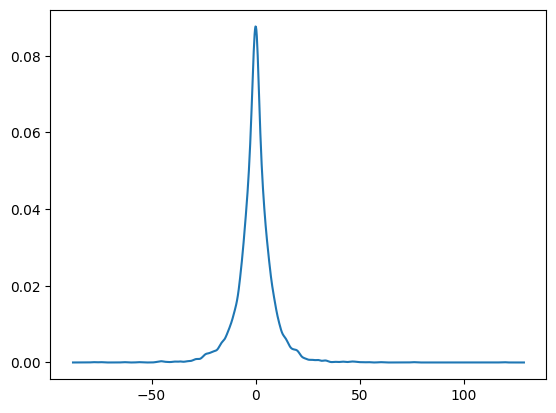

In [15]:
from KDEpy import FFTKDE
import matplotlib.pyplot as plt
x, y = FFTKDE(kernel="gaussian",bw = "silverman").fit(np.array(returns)).evaluate()
plt.plot(x, y)



In [16]:
np.array(data['Adj Close'])

array([ 32.85314178,  32.76677322,  31.82539368, ..., 868.86254883,
       858.0847168 , 864.17218018])

In [17]:
y


array([2.22044605e-16, 2.22044605e-16, 2.22044605e-16, ...,
       2.22044605e-16, 2.22044605e-16, 2.22044605e-16])

In [18]:
np.sum(y)

4.721855746142614

In [19]:
np.sort(np.array(returns))

array([-77.87481689, -74.39697266, -63.17364502, ...,  59.9850769 ,
        75.82830811, 119.07342529])

In [20]:
import torch
import torch.nn as nn


In [21]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, predictions, targets):
        errors = targets - predictions
        quantile_loss = torch.max((self.quantile - 1) * errors, self.quantile * errors)
        return quantile_loss.mean()

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size,dtype=torch.float64)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size,dtype=torch.float64)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [23]:
network = NeuralNetwork(1,5,1)
quantile_loss = QuantileLoss(0.95)

In [24]:
optimizer = torch.optim.SGD(network.parameters(),lr=0.001)
input = np.array(data['Adj Close'])
input=input[0:-1]
input=torch.from_numpy(input)
input= torch.unsqueeze(input, dim=1)
returns=torch.from_numpy(returns)
returns=torch.unsqueeze(returns,dim=1)

In [25]:
for epoch in range(100000):
    outputs = network(input)
    loss = quantile_loss(outputs, returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1000== 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1000, Loss: 0.9340181635607163
Epoch: 2000, Loss: 0.9199384700449511
Epoch: 3000, Loss: 0.919462369376968
Epoch: 4000, Loss: 0.9150929471751733
Epoch: 5000, Loss: 0.910768623956318
Epoch: 6000, Loss: 0.910359186627802
Epoch: 7000, Loss: 0.9099618229935801
Epoch: 8000, Loss: 0.9095742530410138
Epoch: 9000, Loss: 0.9091907582592587
Epoch: 10000, Loss: 0.9088050841359885
Epoch: 11000, Loss: 0.9086999763708171
Epoch: 12000, Loss: 0.9083566269959923
Epoch: 13000, Loss: 0.907990272403388
Epoch: 14000, Loss: 0.9075958673745754
Epoch: 15000, Loss: 0.9072857251372486
Epoch: 16000, Loss: 0.9070111782322983
Epoch: 17000, Loss: 0.906679578513776
Epoch: 18000, Loss: 0.9064549954134279
Epoch: 19000, Loss: 0.9062576977436765
Epoch: 20000, Loss: 0.9059209888908797
Epoch: 21000, Loss: 0.9055966480375723
Epoch: 22000, Loss: 0.9054268682617005
Epoch: 23000, Loss: 0.9515404908255287
Epoch: 24000, Loss: 0.9268229690195519
Epoch: 25000, Loss: 0.9242484527462641
Epoch: 26000, Loss: 0.9139973078875374


In [32]:
outputs=network(input[4071:])
compvalue=returns[4071:]
ans=outputs.detach().numpy()
given=compvalue.detach().numpy()
compvalue.shape

torch.Size([453, 1])

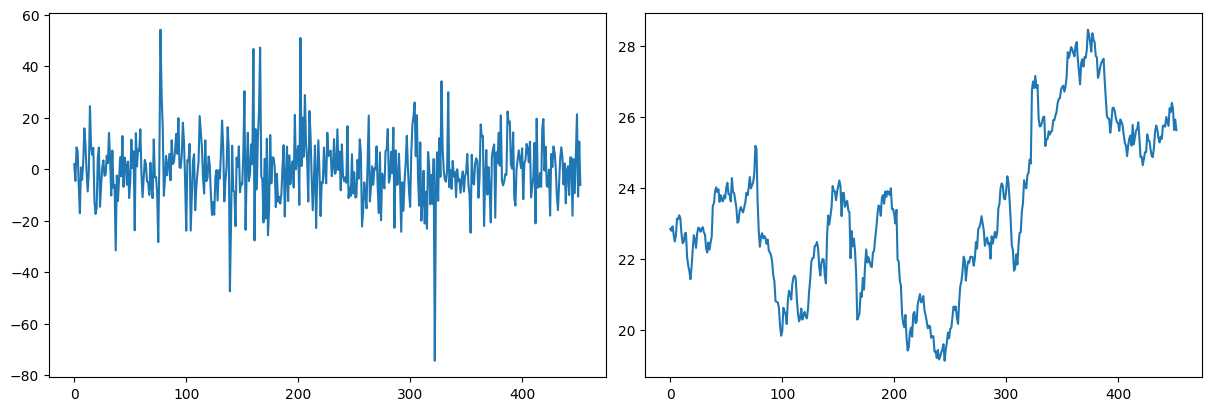

In [34]:
fig,(ax1,ax2)=plt.subplots(1,2,constrained_layout=True,figsize=(12,4))
ax1.plot(returns[4071:])
ax2.plot(ans)

In [35]:
error=ans-given
error


array([[ 20.85519009],
       [ 27.32681078],
       [ 14.44857597],
       [ 15.65943016],
       [ 28.71781404],
       [ 39.75111529],
       [ 22.43680926],
       [ 27.20043887],
       [ 20.23858852],
       [  7.25226261],
       [ 13.2900317 ],
       [ 23.44263223],
       [ 31.09283957],
       [ 23.60852667],
       [ -1.7755762 ],
       [ 13.29088004],
       [ 16.18732523],
       [ 13.34149508],
       [ 33.63814348],
       [ 39.15667148],
       [ 37.39511335],
       [ 18.18380703],
       [ 14.1240883 ],
       [ 36.90901287],
       [ 28.74293115],
       [ 22.13370516],
       [ 19.42281273],
       [ 25.30636586],
       [ 24.92813141],
       [ 17.66226531],
       [ 20.40734354],
       [  8.58478417],
       [ 18.15952668],
       [ 32.39398633],
       [ 15.18882252],
       [ 29.53561534],
       [ 28.49112965],
       [ 54.1662071 ],
       [ 25.94163554],
       [ 35.92368485],
       [ 27.69555025],
       [ 19.33060345],
       [ 26.67431695],
       [ 11

In [38]:
loss=0.0
for i in range(error.shape[0]):
  if(error[i]>0):
    loss=loss+0.95*error[i]
  else:
    loss=loss+(0.05)*(-1)*error[i]
loss=loss/error.shape[0]
loss

array([22.74799556])